In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
BASE_PATH = "data"
POS_PATH = os.path.join(BASE_PATH, "positive")
NEG_PATH = os.path.join(BASE_PATH, "negative")
ANC_PATH = os.path.join(BASE_PATH, "anchor")

In [5]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# NEGATIVE

In [6]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# POSITIVE AND ANCHOR

In [13]:
# Import uuid library to generate unique image names
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\30f4bbd0-0c9b-11f0-8123-088fc3561754.jpg'

In [20]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

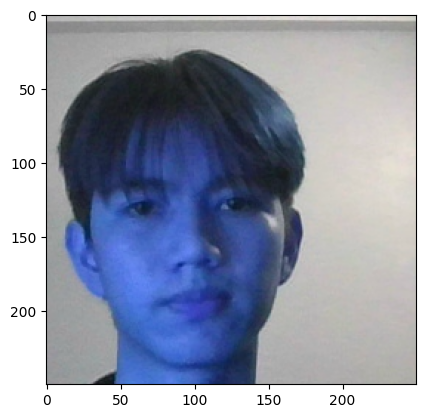

In [19]:
plt.imshow(frame)

# PREPROCESS

In [21]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(20)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(20)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(20)

<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
C:\Users\ACER\AppData\Local\Temp\ipykernel_16168\3922826926.py:1: SyntaxWarning: invalid escape sequence '\*'
  anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(20)
C:\Users\ACER\AppData\Local\Temp\ipykernel_16168\3922826926.py:2: SyntaxWarning: invalid escape sequence '\*'
  positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(20)
C:\Users\ACER\AppData\Local\Temp\ipykernel_16168\3922826926.py:3: SyntaxWarning: invalid escape sequence '\*'
  negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(20)


In [22]:
dir_test = anchor.as_numpy_iterator()

In [23]:
print(dir_test.next())

b'data\\anchor\\05be11f1-0c9c-11f0-afb0-088fc3561754.jpg'


In [4]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    return img

In [26]:
# Create label
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [33]:
samples = data.as_numpy_iterator()

In [34]:
example = samples.next()

In [35]:
example

(b'data\\anchor\\05419f39-0c9c-11f0-ac4d-088fc3561754.jpg',
 b'data\\positive\\09539503-0c9c-11f0-808f-088fc3561754.jpg',
 1.0)

In [36]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [37]:
res = preprocess_twin(*example)

In [46]:
res[2]

1.0

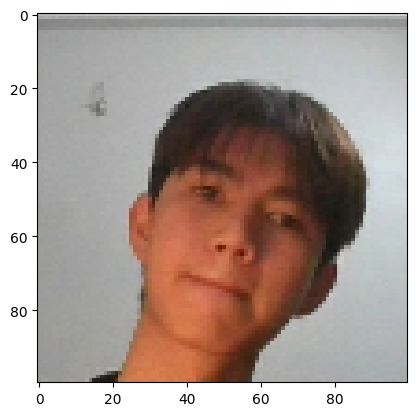

In [64]:
plt.imshow(res[0])

In [53]:
# Build dataloader
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=32)

In [62]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(4)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [63]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(4)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# MODEL

In [5]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [6]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        # Lấy phần tử đầu tiên trong list (vì nó chứa Tensor)
        input_embedding = input_embedding[0] if isinstance(input_embedding, list) else input_embedding
        validation_embedding = validation_embedding[0] if isinstance(validation_embedding, list) else validation_embedding
        
        return tf.math.abs(input_embedding - validation_embedding)


In [8]:
def make_siamese_model(): 

    input_image = Input(name='input_img', shape=(100,100,3))
    
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [9]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# TRAINING

In [100]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [102]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [ ]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [105]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
tf.Tensor(0.6896422, shape=(), dtype=float32)
1/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/steptf.Tensor(0.67959154, shape=(), dtype=float32)
2/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/steptf.Tensor(0.67199075, shape=(), dtype=float32)
3/7 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step tf.Tensor(0.7146716, shape=(), dtype=float32)
4/7 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/steptf.Tensor(0.6498498, shape=(), dtype=float32)
5/7 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/steptf.Tensor(0.59771633, shape=(), dtype=float32)
6/7 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steptf.Tensor(0.48815626, shape=(), dtype=float32)
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step

 Epoch 2/50
tf.Tensor(0.60808486, shape=(), dtype=float32)
1/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/steptf.Tensor(0.29414335, shape=(), dtype=float32)
2/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/steptf.Tensor(0.5679909, shape=(), dtype=float32)
3/7 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step tf.Tensor(0.62817866, shape=(), dtype=float32)
4/7 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/steptf.Tensor(0.35118744, shape=(), dtype=float32)
5/7 ━━━━━━━━━━━━━━━━━

# Evaluate and Save Model

In [106]:
from tensorflow.keras.metrics import Precision, Recall

In [107]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


array([[1.6334445e-04],
       [9.9992877e-01],
       [1.7520548e-04],
       [6.3857222e-08]], dtype=float32)

In [108]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0]

In [109]:
y_true

array([0., 1., 0., 0.], dtype=float32)

In [110]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [111]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

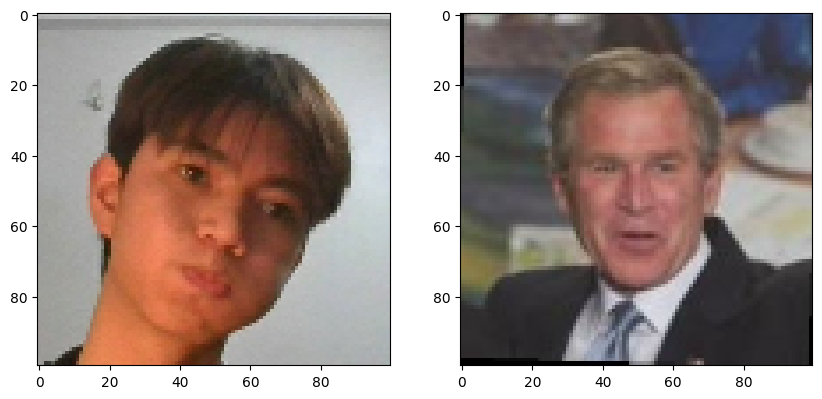

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

In [113]:
siamese_model.save('siamesemodel.h5')

In [10]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [116]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


array([[1.6334445e-04],
       [9.9992877e-01],
       [1.7520548e-04],
       [6.3857222e-08]], dtype=float32)

# Realtime Test

In [16]:
os.listdir(os.path.join('application_data', 'verification_images'))

['085fe011-0c9c-11f0-a7eb-088fc3561754.jpg',
 '09539503-0c9c-11f0-808f-088fc3561754.jpg',
 '0a3bb0cd-0c9c-11f0-9d46-088fc3561754.jpg',
 '0fd98523-0c9c-11f0-90eb-088fc3561754.jpg',
 '68f8fd5a-0ca4-11f0-8447-088fc3561754.jpg',
 '6972f1bc-0ca4-11f0-a89b-088fc3561754.jpg',
 '6c48ca3f-0c9b-11f0-9e65-088fc3561754.jpg',
 '6f516c01-0ca4-11f0-aef0-088fc3561754.jpg',
 '6f77ec83-0ca4-11f0-b78f-088fc3561754.jpg',
 '6fe7d29c-0ca4-11f0-837f-088fc3561754.jpg',
 'c669debb-0c9b-11f0-9c95-088fc3561754.jpg',
 'e55dfc53-0c9b-11f0-a320-088fc3561754.jpg',
 'e9b64563-0c9b-11f0-b45d-088fc3561754.jpg',
 'eae54de5-0c9b-11f0-aa64-088fc3561754.jpg',
 'eb60432d-0c9b-11f0-a6ff-088fc3561754.jpg',
 'ec12c71c-0c9b-11f0-8b9f-088fc3561754.jpg',
 'ec9f248b-0c9b-11f0-bf99-088fc3561754.jpg',
 'f03a8524-0c9b-11f0-84df-088fc3561754.jpg',
 'f11bd095-0c9b-11f0-a055-088fc3561754.jpg',
 'f13caa03-0c9b-11f0-bbe5-088fc3561754.jpg']

In [17]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\085fe011-0c9c-11f0-a7eb-088fc3561754.jpg
application_data\verification_images\09539503-0c9c-11f0-808f-088fc3561754.jpg
application_data\verification_images\0a3bb0cd-0c9c-11f0-9d46-088fc3561754.jpg
application_data\verification_images\0fd98523-0c9c-11f0-90eb-088fc3561754.jpg
application_data\verification_images\68f8fd5a-0ca4-11f0-8447-088fc3561754.jpg
application_data\verification_images\6972f1bc-0ca4-11f0-a89b-088fc3561754.jpg
application_data\verification_images\6c48ca3f-0c9b-11f0-9e65-088fc3561754.jpg
application_data\verification_images\6f516c01-0ca4-11f0-aef0-088fc3561754.jpg
application_data\verification_images\6f77ec83-0ca4-11f0-b78f-088fc3561754.jpg
application_data\verification_images\6fe7d29c-0ca4-11f0-837f-088fc3561754.jpg
application_data\verification_images\c669debb-0c9b-11f0-9c95-088fc3561754.jpg
application_data\verification_images\e55dfc53-0c9b-11f0-a320-088fc3561754.jpg
application_data\verification_images\e9b64563-0c9b-11f0-b45d-088

In [18]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [23]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.6, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━